In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

current_dir = os.getcwd()
file_path = os.path.join(current_dir, 'data','data.graphml')
G = nx.read_graphml(file_path)

# Extract necessary information from the graph
nodes = list(G.nodes())
edges = list(G.edges())

# Initialize an empty list to store regions
regions = []
# Iterate over all nodes in the graph
for n in G.nodes():
    # Get the 'dn_name' attribute of the current node and append it to the regions list
    regions.append(G.nodes[n]['dn_name'])
# Remove duplicate region names
regions = list(set(regions))

# Extract the region name (without the trailing underscore) from each region
regions_name_all = [item.split('_')[0] for item in regions]

# Remove duplicate region names
regions_names = list(set(regions_name_all))

print('nodes:', len(nodes))
print('regions:', len(regions))
print('regions_name_all:', len(regions_name_all))
print('regions_names:', len(regions_names))

nodes: 1015
regions: 1015
regions_name_all: 1015
regions_names: 83


In [2]:
# Create a region-to-region connection matrix
region_connections = pd.DataFrame(0, index=regions_names, columns=regions_names)

#Traverse the edges in the graph and update the connection matrix
for u, v in G.edges():
    if u != v:  # Ignore self-loops
        region_u = G.nodes[u]['dn_name'].split('_')[0]
        region_v = G.nodes[v]['dn_name'].split('_')[0]
        if region_u != region_v:  # Update the number of connections between the two areas to avoid self-loops
            region_connections.loc[region_u, region_v] += 1
            region_connections.loc[region_v, region_u] += 1  # Ensure no repeated statistics

print(len(region_connections))
# Save to CSV file
region_connections.to_csv('region_connections.csv')

83


In [3]:
with open('sort.txt', 'r') as file:
    name_sort = [line.strip() for line in file]

print('name_sort:',len(name_sort))


name_sort: 83


In [4]:
# Create a region-to-region connection matrix and a weight sum matrix
region_connections = pd.DataFrame(0, index=regions_names, columns=regions_names, dtype=int)
weight_sums = pd.DataFrame(0.0, index=regions_names, columns=regions_names, dtype=float)

# Traverse the edges in the graph and update the connection matrix and weight sum
for u, v, data in G.edges(data=True):
    if u != v:  # Ignore self-loops
        region_u = G.nodes[u]['dn_name'].split('_')[0]
        region_v = G.nodes[v]['dn_name'].split('_')[0]
        weight = data['number_of_fiber_per_fiber_length_mean'] 
        if region_u != region_v:  # Update the number of connections and the sum of weights between the two areas to avoid self-loops
            region_connections.loc[region_u, region_v] += 1
            region_connections.loc[region_v, region_u] += 1
            weight_sums.loc[region_u, region_v] += weight
            weight_sums.loc[region_v, region_u] += weight

# Calculate average weight
average_weights = weight_sums.div(region_connections.replace(0, np.nan))

# Sort the DataFrame using the name_sort list
sorted_region_connections = region_connections.reindex(index=name_sort, columns=name_sort)
sorted_average_weights = average_weights.reindex(index=name_sort, columns=name_sort)



In [5]:
# View basic descriptive statistics
print(sorted_average_weights.describe())

# Calculate the overall average weight
mean_weight = sorted_average_weights.mean().mean()
print("Overall mean weight:", mean_weight)

# Find the maximum and minimum average weight
max_weight = sorted_average_weights.max().max()
min_weight = sorted_average_weights.min().min()
print("Maximum average weight:", max_weight)
print("Minimum average weight:", min_weight)

# Find the standard deviation of the weights
std_deviation = sorted_average_weights.stack().std()
print("Standard deviation of weights:", std_deviation)

# Check how many region pairs have an average connection weight of 0 (or very close to 0)
zero_connections = sorted_average_weights.isna().sum().sum()
print("Number of region pairs with no connections:", zero_connections)


       lh.lateralorbitofrontal  lh.parsorbitalis  lh.frontalpole  \
count                 6.000000               0.0             0.0   
mean                  3.295960               NaN             NaN   
std                   1.454765               NaN             NaN   
min                   2.000000               NaN             NaN   
25%                   2.200000               NaN             NaN   
50%                   3.100000               NaN             NaN   
75%                   3.600000               NaN             NaN   
max                   5.909091               NaN             NaN   

       lh.medialorbitofrontal  lh.parstriangularis  lh.parsopercularis  \
count                5.000000             4.000000            5.000000   
mean                 3.546667             3.006250            3.425000   
std                  1.730382             0.875684            1.903122   
min                  2.000000             2.000000            2.000000   
25%              

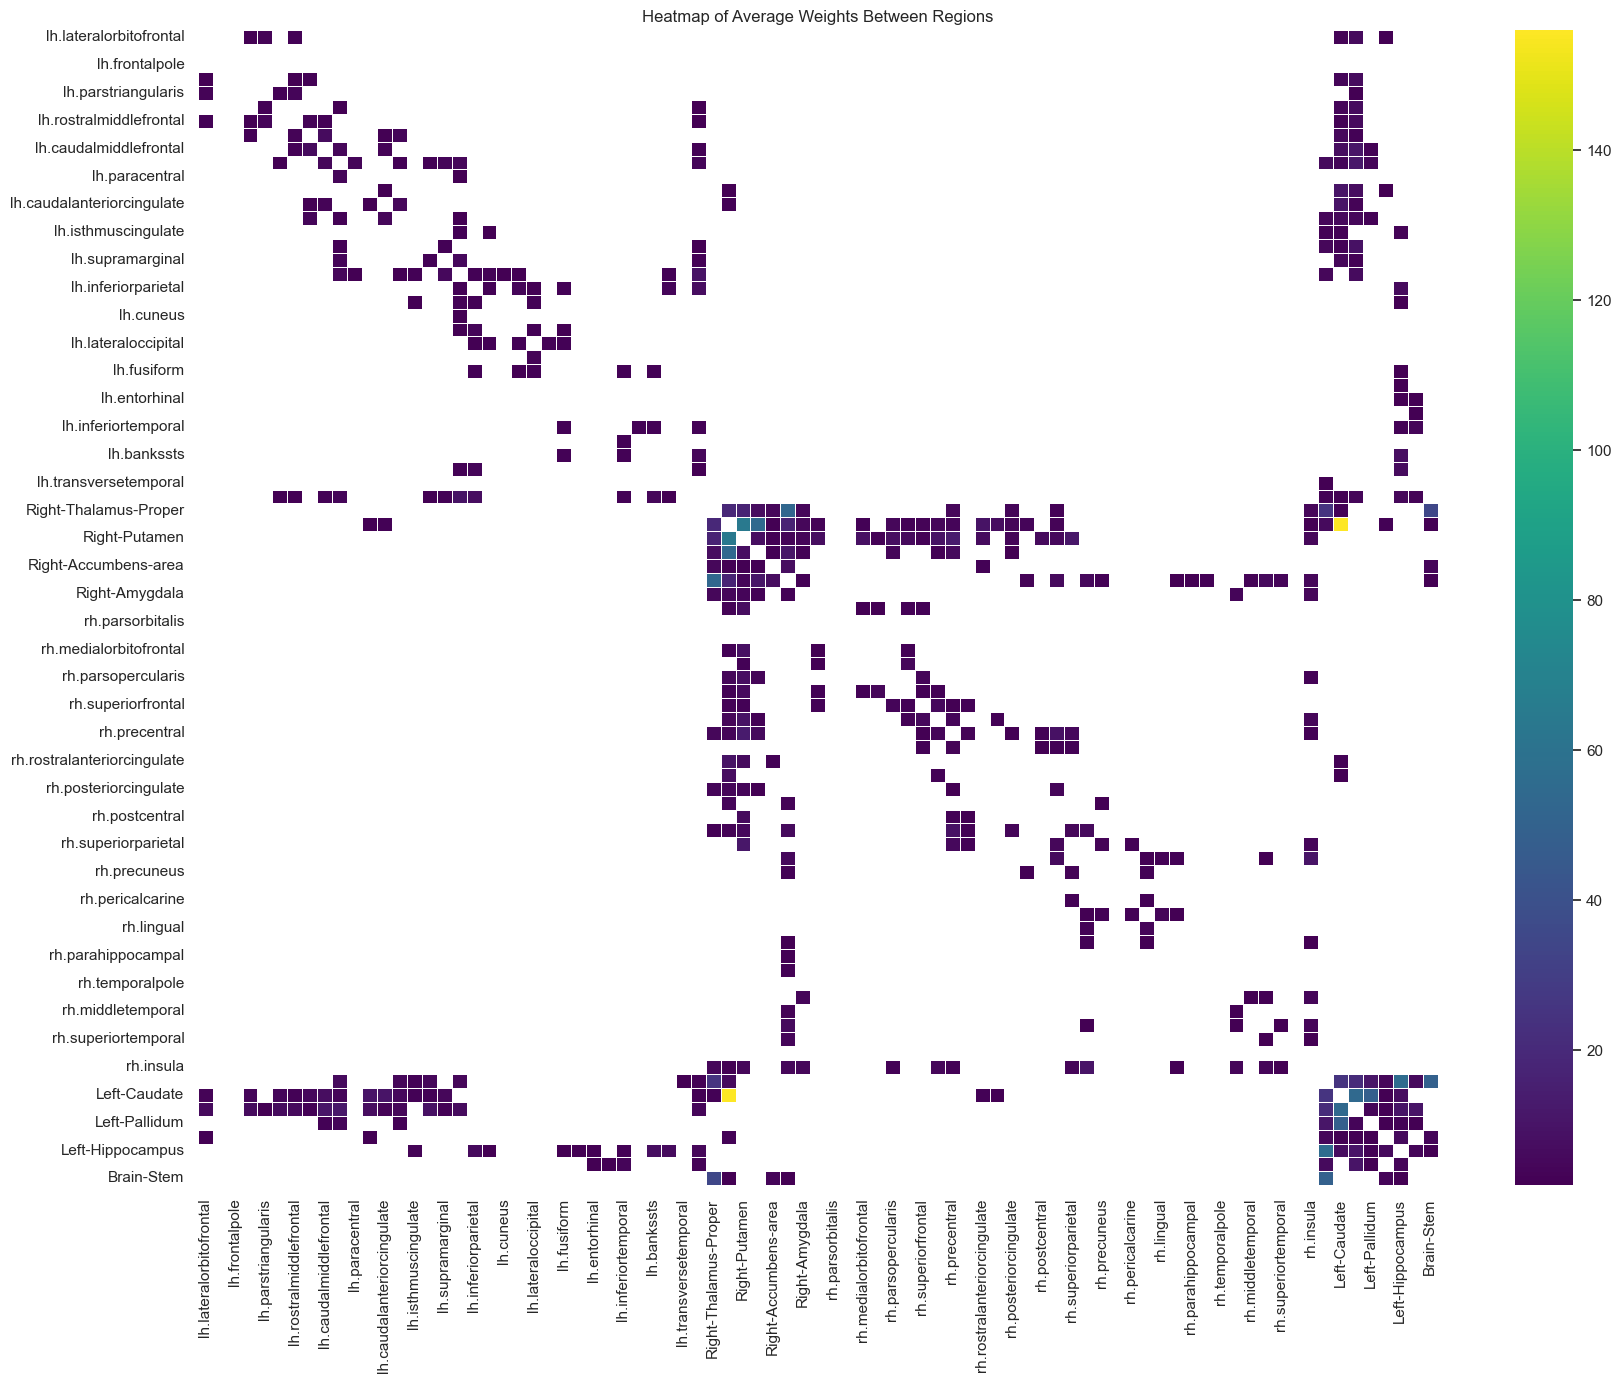

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="white")
plt.figure(figsize=(20, 15)) 
ax = sns.heatmap(sorted_average_weights, annot=False, cmap='viridis', linewidths=.5)
ax.set_title('Heatmap of Average Weights Between Regions')
plt.xticks(rotation=90) 
plt.yticks(rotation=0)
plt.show()


Verify according to graphml, for example, brain stem, node 1015, not counting self-loop (connecting to itself), there are 7 connections in total, 

id weight:
502 35
503 2
506 4
507 2
1008 49
1012 4
1013 2

weights_sum/number_of_connections = 14 is much larger than 9.8, the reason may be that the default parameter amount is too small 1000 edges, so the value is too large

In [15]:
import pandas as pd
import networkx as nx
import os
import numpy as np
import plotly.graph_objects as go

current_dir = os.getcwd()
Nodes_file_path = os.path.join(current_dir, 'data','Categorized_Brain_Nodes_new.csv')
node_data = pd.read_csv(Nodes_file_path)
connections = pd.read_csv('sorted_region_connections.csv', index_col=0)
G = nx.Graph()

#Add nodes and node attributes
for idx, row in node_data.iterrows():
    G.add_node(row['Region'], pos=(row['X'], row['Y'], row['Z']), label=row['Super_Region'])

#Add edge
for i, row in connections.iterrows():
    for j, value in row.items():
        # Only add connections that exist and are not self-looping
        if value > 0 and i!= j:  
            G.add_edge(i, j, weight=value)

# Define label to color mapping
label_colors = {
    'frontal': (1.0, 0.0, 0.0),         
    'parietal': (1.0, 0.65, 0.0),       
    'occipital': (0.68, 1.0, 0.18),     
    'temporal': (0.0, 0.75, 1.0),       
    'limbic': (0.12, 0.56, 1.0),        
    'basal_ganglia': (0.0, 0.0, 1.0),   
    'brain_stem': (0.0, 0.0, 0.0)       
}

# Create a node color list using label to color mapping
node_colors = [label_colors[G.nodes[node]['label']] for node in G.nodes()]

pos = {node: (G.nodes[node]['pos'][0], G.nodes[node]['pos'][1], G.nodes[node]['pos'][2]) for node in G.nodes()}  # 使用x, y, z位置信息

# Create a 3D scatter plot for nodes
node_xyz = np.array([pos[node] for node in G.nodes()])

node_trace = go.Scatter3d(
    x=node_xyz[:, 0],
    y=node_xyz[:, 1],
    z=node_xyz[:, 2],
    mode='markers',
    marker=dict(
        size=8,
        color=node_colors,  
        opacity=0.9
    ),
    hoverinfo='text',
    text=[f"{node} ({G.nodes[node]['label']})" for node in G.nodes()],
    name=None  
)


# Add labels and color annotations
labels = list(set(node_data['Super_Region']))
# Add labels and color annotations
color_annotations = []
for idx, (label, color) in enumerate(label_colors.items()):
    # Convert the RGB value of the color to a floating point number between 0 and 1
    r = min(1, max(0, color[0]))  
    g = min(1, max(0, color[1]))  
    b = min(1, max(0, color[2]))  
    color_str = "rgba({}, {}, {}, 1.0)".format(int(r*255), int(g*255), int(b*255))
    # Calculate the y coordinate of the label
    label_y = 1 - ((idx + 0.5) / len(label_colors))
    #Add label text
    color_annotations.append(dict(
        xref="paper",
        yref="paper",
        x=0.95,
        y=label_y,
        text=f"{label}",
        font=dict(size=12, color="black"),
        showarrow=False
    ))
    #Add color bar
    color_annotations.append(dict(
        xref="paper",
        yref="paper",
        x=0.97,
        y=label_y,
        text='',
        bgcolor=color_str,
        showarrow=False,
        width=10,
        height=10,
    ))

# Create a 3D line plot for edges
edge_xyz = []
for edge in G.edges():
    edge_xyz.extend([pos[edge[0]], pos[edge[1]]])
edge_xyz = np.array(edge_xyz)
edge_trace = go.Scatter3d(
    x=edge_xyz[:, 0],
    y=edge_xyz[:, 1],
    z=edge_xyz[:, 2],
    mode='lines',
    line=dict(color='gray', width=0.5),
    hoverinfo='none'
)

# Create the 3D plot
fig = go.Figure(data=[node_trace, edge_trace])
fig.update_layout(
    width=1200,
    height=800, 
    scene=dict(
        camera=dict(
            eye=dict(x=-0.9, y=-0.9, z=0.9),  # Set the initial viewing position
            center=dict(x=0, y=0, z=0),         # Set the center of the view
            up=dict(x=0, y=0, z=1),             # Set the up direction
        ),
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    ),
    margin=dict(r=10, l=10, b=10, t=10),
    annotations=color_annotations
)



# Show the plot
fig.show()

![Optional Title](Fig01.png)
